# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [74]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [75]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

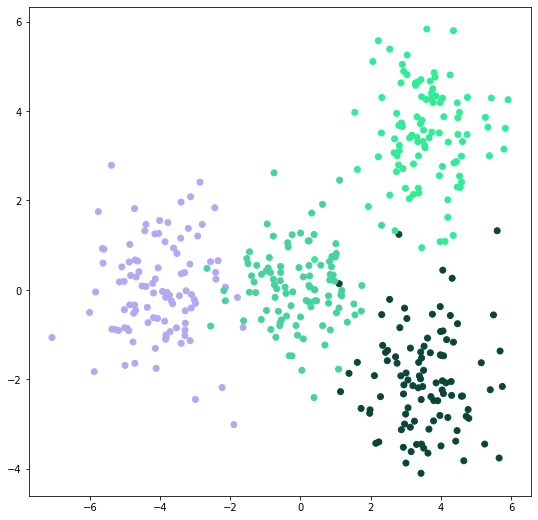

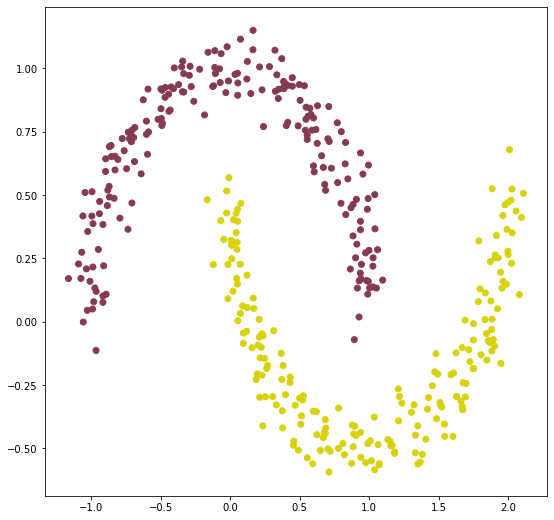

In [76]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [97]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter=max_iter
        self.init = init
            
        
    def fit(self, X, y=None):
        self.centroids = []
        if self.init == 'random':
            for i in range(self.n_clusters):
                self.centroids.append([random.uniform(min(X[:,0]), max(X[:,0])), random.uniform(min(X[:,1]), max(X[:,1]))])
        if self.init == 'sample':
            for i in range(self.n_clusters):
                self.centroids.append(list(random.choice(X)))
        if self.init == 'k-means++':
            for i in range(self.n_clusters):
                self.centroids.append(list(random.choice(X)))
            for i in range(self.n_clusters):
                dist = []
                sum_dist = 0
                for j in range(len(X)):
                    new = min([(self.centroids[l][0] - X[l][0])**2 \
                               + (self.centroids[l][1] - X[l][1])**2 for l in range(self.n_clusters)])
                    sum_dist += new
                    dist.append(new)
                rnd = random.uniform(0, sum_dist)
                sum_dist = 0
                j = 0
                while sum_dist < rnd:
                    sum_dist += dist[j]
                    j += 1
                self.centroids[i] = X[j]
        
        for i in range(self.max_iter):
            closest_centroids = []
            for j in range(len(X)):
                closest_centroids.append(np.argmin([(self.centroids[l][0] - X[j][0])**2 \
                                                    + (self.centroids[l][1] - X[j][1])**2 for l in range(self.n_clusters)]))
            for j in range(self.n_clusters):
                if closest_centroids.count(j) != 0:
                    x = 1/(closest_centroids.count(j))*sum([X[l][0] for l in range(len(X)) if closest_centroids[l] == j])
                    y = 1/(closest_centroids.count(j))*sum([X[l][1] for l in range(len(X)) if closest_centroids[l] == j])
                    self.centroids[j] = [x, y]
            
    
    def predict(self, X):
        ans = []
        for i in range(len(X)):
            ans.append(np.argmin([(self.centroids[l][0] - X[i][0])**2 \
                                                        + (self.centroids[l][1] - X[i][1])**2 for l in range(self.n_clusters)]))
        return ans

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

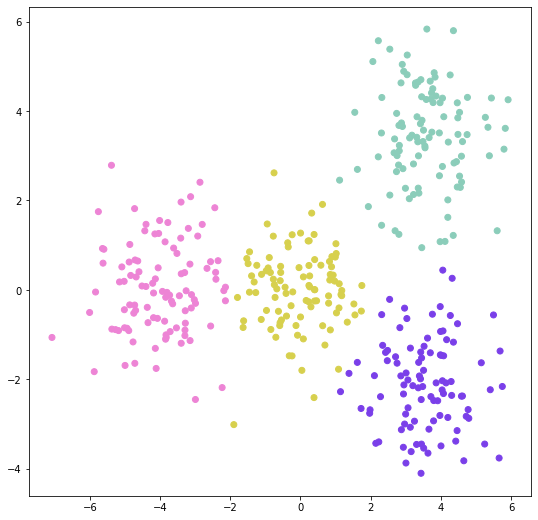

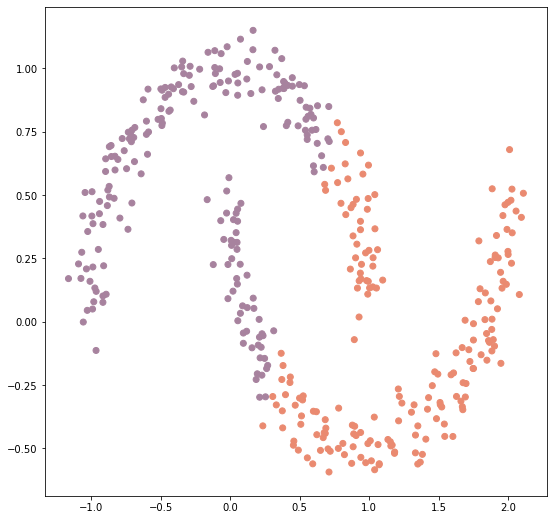

Wall time: 6.76 s


In [102]:
%%time
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [87]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def clust(self, i):
        if self.clusters[i] == 0:
            self.clusters[i] = self.count_clasters
            points = self.tree.query_radius(self.X, self.eps)[i]
            if len(points) >= self.min_samples + 1:
                for point in points:
                    self.clust(point)
                    
    def fit_predict(self, X, y=None):
        self.X = X
        self.clusters = [0]*len(X)
        self.count_clasters = 0
        self.tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        for i in range(len(X)):
            if self.clusters[i] == 0:
                if len(self.tree.query_radius(self.X, self.eps)[i]) >= self.min_samples + 1:
                    self.count_clasters += 1
                    self.clust(i)
        if self.clusters.count(0) == 0:
            for i in range(len(X)):
                self.clusters[i] -= 1
        return self.clusters

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

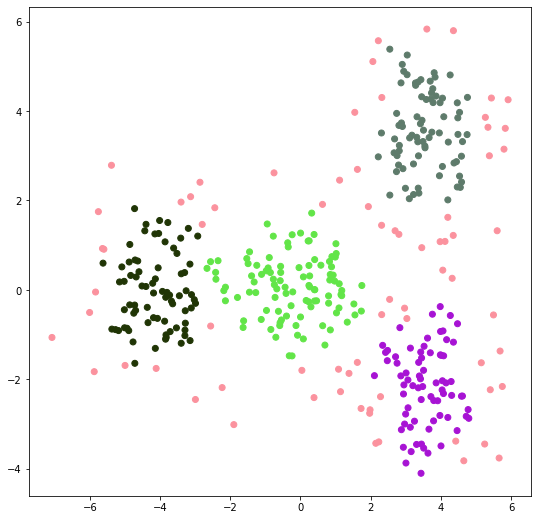

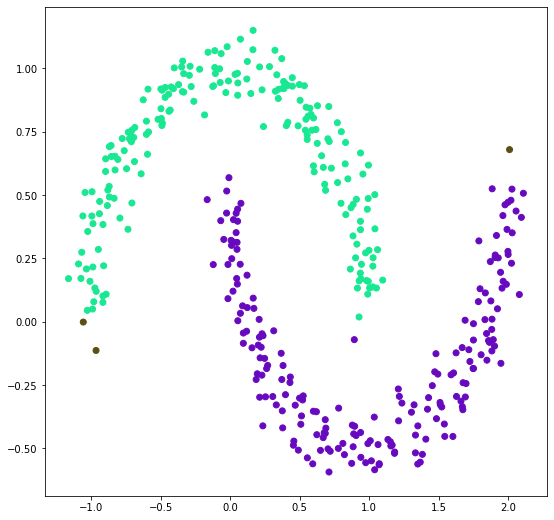

In [94]:
dbscan = DBScan(eps=0.55, min_samples=5)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)
dbscan = DBScan(eps=0.3, min_samples=30, leaf_size=40)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [69]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.link = linkage
        self.n_clusters = n_clusters
    def linkage(self, X, Y):
        aver = []
        for i in range(len(X)):
            for j in range(len(Y)):
                aver.append(((X[i][0]-Y[j][0])**2 + (X[i][1]-Y[j][1])**2)**(0.5))
        if self.link == 'average':
            return sum(aver)/len(aver)
        elif self.link == 'single':
            return min(aver)
        else:
            return max(aver)
        
    def fit_predict(self, X, y=None):
        inf = 10000
        clasters = []
        for i in range(len(X)):
            clasters.append([X[i]])
        labels = []
        min_dist = inf
        while(len(clasters) != self.n_clusters):
            for i in range(len(clasters)):
                for j in range(i + 1, len(clasters)):
                    dist = self.linkage(clasters[i], clasters[j])
                    if dist < min_dist:
                        min_dist = dist
                        coors = [i, j]
            min_dist = inf
            clasters[coors[0]] = np.concatenate([clasters[coors[0]], clasters[coors[1]]])
            del clasters[coors[1]]
        
        for x in X:
            for index, clust in enumerate(clasters):
                if np.array(x) in np.array(clust):
                    labels.append(index)
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

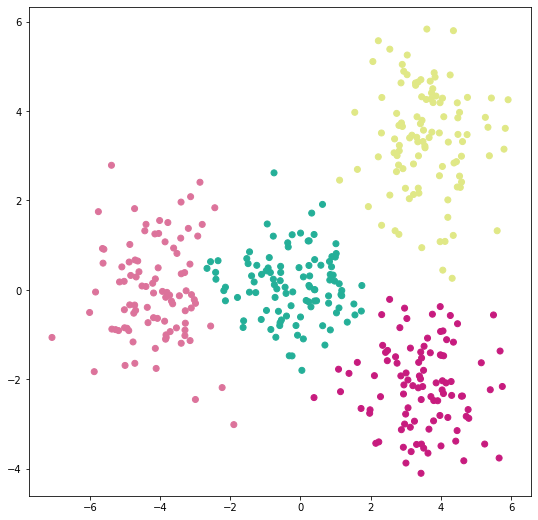

In [95]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

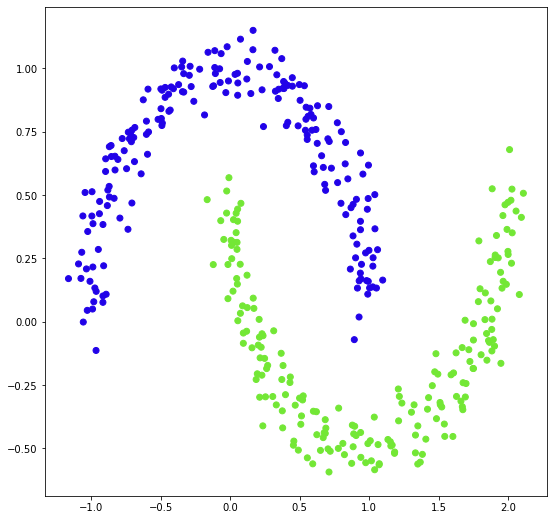

In [96]:
agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)